# Generación de texto con RNN (encoder-decoder) en TensorFlow

## Imports

In [46]:
import tensorflow as tf
import numpy as np
import os
import time
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Mean


warnings.filterwarnings("ignore")
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"


## Cargamos y extraemos el texto de Don Quijote 

In [2]:
# https://www.gutenberg.org/
url_don_quijote = "https://www.gutenberg.org/cache/epub/2000/pg2000.txt"
path_to_file = tf.keras.utils.get_file('don_quijote.txt', url_don_quijote)

In [3]:
with open(path_to_file, "r", encoding="utf-8") as f:
    full_text = f.read()

start_marker = "*** START OF THE PROJECT GUTENBERG EBOOK DON QUIJOTE ***"
end_marker   = "*** END OF THE PROJECT GUTENBERG EBOOK DON QUIJOTE ***"

start_index = full_text.find(start_marker)
end_index   = full_text.find(end_marker)

if start_index == -1 or end_index == -1:
    # Si no se encuentran los marcadores:
    print("No se han encontrado los marcadores en el texto. Revisa si la URL o el texto han cambiado.")
else:
    # Extrae solo la parte que nos interesa
    # Sumamos la longitud de start_marker para no quedarnos con la línea entera
    main_text = full_text[start_index + len(start_marker):end_index]

    # Limpiamos espacios o saltos de línea excesivos al inicio y final
    main_text = main_text.strip()

    print("Texto principal extraído. Longitud:", len(main_text))
    print("Fragmento inicial:\n", main_text[:500])
    print("...\nFragmento final:\n", main_text[-500:])

Texto principal extraído. Longitud: 2110726
Fragmento inicial:
 El ingenioso hidalgo don Quijote de la Mancha



por Miguel de Cervantes Saavedra





El ingenioso hidalgo don Quijote de la Mancha


  
Tasa

  
Testimonio de las erratas

  
El Rey

  
Al Duque de Béjar

  
Prólogo

  
Al libro de don Quijote de la Mancha



Que trata de la condición y ejercicio del famoso
hidalgo don Quijote de la Mancha

Que trata de la primera salida que de su tierra hizo
el ingenioso don Quijote

Donde se cuenta la graciosa manera que tuvo don
Quijote en armarse caballero
...
Fragmento final:
 en éstos como en los estraños reinos''. Y con esto cumplirás
con tu cristiana profesión, aconsejando bien a quien mal te quiere, y yo
quedaré satisfecho y ufano de haber sido el primero que gozó el fruto de
sus escritos enteramente, como deseaba, pues no ha sido otro mi deseo que
poner en aborrecimiento de los hombres las fingidas y disparatadas
historias de los libros de caballerías, que, por las de mi verdad

## Preprocesamiento de datos

### Crear el vocabulario de caracteres

- Vamos a extraer todos los caracteres únicos del texto. Esto nos permitirá construir un vocabulario con el que podamos asignar un ID numérico a cada carácter.

In [4]:
vocab = sorted(set(main_text))
print("Caracteres únicos en el Quijote:", len(vocab))
print(vocab)

Caracteres únicos en el Quijote: 92
['\n', ' ', '!', '"', "'", '(', ')', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', ']', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'x', 'y', 'z', '¡', '«', '»', '¿', 'Á', 'É', 'Í', 'Ñ', 'Ó', 'Ú', 'à', 'á', 'é', 'í', 'ï', 'ñ', 'ó', 'ù', 'ú', 'ü', '—']


### Mapear caracteres a enteros (y viceversa)

#### Vectorización de caracteres con `StringLookup`

Antes de entrenar el modelo, necesitamos transformar el texto en una forma que pueda ser procesada por una red neuronal. Para ello, utilizamos la capa [`StringLookup`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/StringLookup) de Keras, que convierte caracteres en IDs numéricos y viceversa.

Concretamente:

- `ids_from_chars`: mapea cada carácter del texto a un número entero.
- `chars_from_ids`: hace la operación inversa, recuperando el carácter original a partir del ID.

Este mapeo es fundamental para:
- Codificar el texto como secuencias numéricas que puedan ser entendidas por el modelo.
- Convertir las predicciones del modelo (que serán también IDs) de vuelta a texto legible.

##### ¿Qué es `[UNK]`?

Cuando usamos `StringLookup`, cualquier carácter desconocido que no esté en el vocabulario se asigna por defecto al token `[UNK]` (abreviación de “unknown”). Esto permite manejar entradas inesperadas o erróneas sin que el modelo falle, aunque lo ideal es que el vocabulario contenga todos los caracteres relevantes del texto.

En este caso, como extraemos los caracteres únicos directamente del texto original del Quijote, **el vocabulario está perfectamente alineado con los datos**, por lo que no deberíamos ver `[UNK]` en la práctica. Aun así, la capa lo reserva por defecto como una opción de seguridad.

In [5]:
# Crear el mapeo de caracteres a IDs
ids_from_chars = tf.keras.layers.StringLookup(
    vocabulary=list(vocab), mask_token=None
)

# Crear el mapeo inverso de IDs a caracteres
chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None
)

# Función para convertir una secuencia de IDs a texto
def text_from_ids(ids):
    return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)


I0000 00:00:1743934365.966342    5215 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5558 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6


In [6]:
# Estas capas son muy útiles porque permiten mantener la trazabilidad entre el texto original y las representaciones numéricas que procesará el modelo.
type(chars_from_ids), type(ids_from_chars)

(keras.src.layers.preprocessing.string_lookup.StringLookup,
 keras.src.layers.preprocessing.string_lookup.StringLookup)

#### Visualización del mapeo

Para comprobar que la codificación y decodificación funcionan correctamente, mostramos un ejemplo sencillo.

Esto nos permite ver que:

- El texto `"Don Quijote"` se convierte en una secuencia de enteros.
- Esa secuencia puede ser transformada de nuevo en el texto original, garantizando que el mapeo es bidireccional y preciso.

Esta visualización es útil como prueba de validación antes de continuar con el preprocesamiento del corpus completo.

In [7]:
example_chars = tf.constant(list("Don Quijote"))
char_ids = ids_from_chars(example_chars)
reconstructed = chars_from_ids(char_ids)

print("Caracteres:", example_chars.numpy())
print("IDs:", char_ids.numpy())
print("Reconstruido:", reconstructed.numpy())


Caracteres: [b'D' b'o' b'n' b' ' b'Q' b'u' b'i' b'j' b'o' b't' b'e']
IDs: [25 61 60  2 37 67 56 57 61 66 52]
Reconstruido: [b'D' b'o' b'n' b' ' b'Q' b'u' b'i' b'j' b'o' b't' b'e']


### Conversión del texto completo a IDs y verificación visual

Aplicamos ahora `ids_from_chars` a todo el texto para convertir cada carácter en un ID numérico, generando así la secuencia completa que servirá como entrada para el modelo.

Esto transforma el corpus textual en una serie de números enteros que codifican el texto carácter por carácter, preservando el estilo y la estructura.

- Verificación

    Para asegurarnos de que esta conversión es correcta:

    - Mostramos los primeros 40 caracteres del texto y sus correspondientes IDs.
    - Reconstruimos esos IDs de nuevo a texto usando `chars_from_ids`.
    - Visualizamos ambos (carácter e ID) en una tabla para confirmar que el proceso de codificación y decodificación es simétrico.

    Esto es crucial para garantizar que el modelo reciba los datos en el formato correcto, y que luego podamos interpretar sus predicciones sin ambigüedades.


In [8]:
# Convertimos el texto completo a una secuencia de IDs (enteros)
all_ids = ids_from_chars(tf.strings.unicode_split(main_text, input_encoding="UTF-8"))

# Verificación rápida
print("· Primeros 10 IDs:", all_ids[:40].numpy())
print("\n· Reconstrucción:", text_from_ids(all_ids[:40]).numpy().decode("utf-8"))


· Primeros 10 IDs: [26 58  2 56 60 54 52 60 56 61 65 61  2 55 56 51 48 58 54 61  2 51 61 60
  2 37 67 56 57 61 66 52  2 51 52  2 58 48  2 33]

· Reconstrucción: El ingenioso hidalgo don Quijote de la M


In [9]:
df = pd.DataFrame({
    "Carácter": list(main_text[:40]),
    "ID": all_ids[:40].numpy()
})
df.transpose()

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
Carácter,E,l,,i,n,g,e,n,i,o,...,t,e,,d,e,,l,a,,M
ID,26,58,2,56,60,54,52,60,56,61,...,66,52,2,51,52,2,58,48,2,33


### Crear secuencias a partir del texto vectorizado

Ya hemos transformado el texto completo en una secuencia de IDs (`all_ids`).  
Ahora necesitamos dividir esa secuencia larga en **subsecuencias de longitud fija**, que representarán:

- El **input** que le damos al modelo
- Y el **target** que esperamos que prediga (el siguiente carácter tras cada input)


¿Cómo se hace?

1. Elegimos un valor de `seq_length`, por ejemplo 250.  
2. Tomamos fragmentos consecutivos del tipo:
   - Input: los primeros 250 caracteres
   - Target: los mismos 250 desplazados una posición hacia adelante

    Ejemplo simplificado con `seq_length = 5`:

    | Input IDs     | Target IDs    |
    |---------------|---------------|
    | [1, 2, 3, 4, 5] | [2, 3, 4, 5, 6] |

#### Preparación con `tf.data.Dataset`

- TensorFlow nos permite convertir directamente la secuencia de enteros (`all_ids`) en un dataset eficiente usando `tf.data.Dataset.from_tensor_slices()`.  
- Luego agrupamos por ventanas de longitud `seq_length + 1`, y usamos una función auxiliar para separar cada fragmento en `(input, target)`.

Al final, barajamos y preparamos el dataset en batches para el entrenamiento.

In [10]:
# Longitud de cada secuencia de entrada (puedes cambiarlo)
seq_length = 250

# Dividimos la secuencia en segmentos de longitud seq_length + 1
sequences = tf.data.Dataset.from_tensor_slices(all_ids)
sequences = sequences.batch(seq_length + 1, drop_remainder=True)

# Función que separa input y target
def split_input_target(seq):
    input_seq = seq[:-1]   # todos excepto el último
    target_seq = seq[1:]   # todos excepto el primero
    return input_seq, target_seq

# Aplicamos la transformación
dataset = sequences.map(split_input_target)

# Verificación más clara y acotada
for input_example, target_example in dataset.take(1):
    input_text = text_from_ids(input_example).numpy().decode("utf-8")
    target_text = text_from_ids(target_example).numpy().decode("utf-8")

    print("🔹 Input (primeros 50 caracteres):")
    print("IDs del input:", input_example[:10].numpy())
    print(repr(input_text[:50]))
    print("\n🔸 Target (primeros 50 caracteres):")
    print("IDs del target:", target_example[:10].numpy())
    print(repr(target_text[:50]))



🔹 Input (primeros 50 caracteres):
IDs del input: [26 58  2 56 60 54 52 60 56 61]
'El ingenioso hidalgo don Quijote de la Mancha\n\n\n\np'

🔸 Target (primeros 50 caracteres):
IDs del target: [58  2 56 60 54 52 60 56 61 65]
'l ingenioso hidalgo don Quijote de la Mancha\n\n\n\npo'


2025-04-06 12:12:46.629537: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Preparar el dataset para entrenamiento

- Una vez generadas las secuencias `(input, target)`, es hora de preparar el dataset para que pueda ser usado durante el entrenamiento del modelo de forma eficiente.


**¿Qué pasos seguimos?**

1. **Mezclar (shuffle)**  
    - Esto evita que el modelo aprenda dependencias artificiales del orden original del texto.
    - Usamos un búfer grande para garantizar una mezcla adecuada (por ejemplo, 10.000 elementos).

2. **Agrupar en batches**  
    - Procesamos varios ejemplos a la vez durante el entrenamiento.
    - Esto acelera el proceso y permite que el modelo aprenda de patrones en paralelo.

3. **Prefetching**  
    - Prepara los siguientes batches mientras se entrena con los actuales.
    - Mejora el rendimiento y reduce el tiempo de espera entre pasos de entrenamiento.

Con esta preparación, el dataset estará optimizado tanto en términos de memoria como de velocidad de procesamiento.

In [11]:
# Parámetros
BATCH_SIZE = 128
BUFFER_SIZE = 10000

# Mezclamos, agrupamos en batches y activamos prefetching
dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

# Dividir el dataset en entrenamiento y validación
total_batches = dataset.cardinality().numpy()
print("Total de batches:", total_batches)
val_batches = total_batches // 10  # 10% para validación
val_dataset = dataset.take(val_batches)
train_dataset = dataset.skip(val_batches)

# Verificamos la estructura final del dataset
for input_batch, target_batch in dataset.take(1):
    print("Shape del input:", input_batch.shape)
    print("Shape del target:", target_batch.shape)


Total de batches: 65
Shape del input: (128, 250)
Shape del target: (128, 250)


2025-04-06 12:12:47.652088: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Definir el modelo RNN



- Ya tenemos los datos listos. Ahora construiremos el modelo neuronal que será capaz de **predecir el siguiente carácter** dado un fragmento previo.


### Arquitectura utilizada

Definimos el modelo como una subclase de `tf.keras.Model`. Está compuesto por tres capas principales:

1. **`Embedding`**  
   Convierte IDs de caracteres en vectores densos de dimensión fija. Esto permite al modelo aprender representaciones útiles de cada carácter.

2. **`GRU` (Gated Recurrent Unit)**  
   Capa recurrente que captura relaciones temporales.  
   La configuramos con `return_sequences=True` y `return_state=True` para que devuelva toda la secuencia de salidas y el estado final (cuando lo necesitemos).

3. **`Dense`**  
   Capa de salida que produce una predicción de probabilidad para cada carácter del vocabulario.

### Hiperparámetros

- `vocab_size`: cantidad total de caracteres únicos que reconoce el modelo.
- `embedding_dim`: dimensión de los vectores de embedding.
- `rnn_units`: número de neuronas en la GRU.

Esta arquitectura, aunque sencilla, es adecuada para generar texto en el estilo del Quijote.


In [12]:
# ------------------------------------------------------------
# Hiperparámetros del modelo
# ------------------------------------------------------------

# Número total de caracteres únicos (vocabulario del modelo)
# Incluye el token especial [UNK] usado por StringLookup
vocab_size = len(ids_from_chars.get_vocabulary())

# Dimensión de los vectores de embedding (puedes ajustar)
embedding_dim = 128

# Número de unidades en la GRU (tamaño del estado oculto)
rnn_units = 1250 

# ------------------------------------------------------------
# Definición del modelo como subclase de tf.keras.Model
# ------------------------------------------------------------
class MyModel(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, rnn_units):
        super().__init__()  # Inicializa la clase base tf.keras.Model

        # Capa de Embedding: transforma cada ID en un vector denso
        self.embedding = tf.keras.layers.Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim
        )

        # Capa GRU: procesa secuencias manteniendo memoria a lo largo del tiempo
        self.gru = tf.keras.layers.GRU(
            units=rnn_units,
            return_sequences=True,  # Devuelve salida en cada paso
            return_state=True       # También devuelve el estado final
        )

        # Capa densa final: proyecta la salida de la GRU a un vector del tamaño del vocabulario
        self.dense = tf.keras.layers.Dense(units=vocab_size)

    def call(self, inputs, states=None, return_state=False, training=False):
        # 1. Embedding
        x = self.embedding(inputs, training=training)
        # 2. Procesamiento con GRU
        outputs = self.gru(x, initial_state=states, training=training)
        if return_state:
            x, states = outputs  # Desempaqueta (output_sequence, estado_final)
            x = self.dense(x, training=training)
            return x, states
        else:
            x = outputs[0] if isinstance(outputs, tuple) else outputs
            x = self.dense(x, training=training)
            return x

# ------------------------------------------------------------
# Creamos una instancia del modelo
# ------------------------------------------------------------

model = MyModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units
)

# ------------------------------------------------------------
# Verificamos la forma de entrada y salida con un batch
# ------------------------------------------------------------

for input_example_batch, _ in dataset.take(1):
    example_batch_predictions = model(input_example_batch)

# Mostramos la forma esperada
print("Shape del input:", input_example_batch.shape)         # (batch_size, seq_length)
print("Shape del output:", example_batch_predictions.shape)  # (batch_size, seq_length, vocab_size)


Shape del input: (128, 250)
Shape del output: (128, 250, 93)


I0000 00:00:1743934369.957781    5673 cuda_dnn.cc:529] Loaded cuDNN version 90800


### Ejemplo de predicción antes del entrenamiento



Antes de entrenar el modelo, es útil observar cómo se comporta al recibir una secuencia de entrada.  
Aunque aún no ha aprendido nada útil, **sí nos permite verificar** que la arquitectura está funcionando correctamente.

¿Qué haremos?

1. Tomamos una secuencia real del dataset como entrada.
2. Pasamos esta secuencia por el modelo.
3. Obtenemos las predicciones para cada carácter.
4. Usamos `tf.random.categorical` para **muestrear** los próximos caracteres según las probabilidades predichas.
5. Visualizamos y comparamos los resultados.

Este proceso nos ayuda a **entender cómo genera texto carácter a carácter**, y servirá como referencia visual para comparar más adelante con el modelo ya entrenado.


In [13]:
# ------------------------------------------------------------
# Seleccionamos un batch de ejemplo y obtenemos las predicciones
# ------------------------------------------------------------
for input_example_batch, _ in dataset.take(1):
    predictions = model(input_example_batch)  # (batch_size, seq_length, vocab_size)
    input_example = input_example_batch[0]    # Tomamos solo una secuencia
    prediction_logits = predictions[0]        # Logits predichos para esa secuencia (shape: [seq_length, vocab_size])

# ------------------------------------------------------------
# Usamos tf.random.categorical para muestrear los próximos caracteres
# ------------------------------------------------------------

# Para cada paso de la secuencia, elegimos un carácter basado en la distribución predicha
sampled_indices = tf.random.categorical(prediction_logits, num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()

# ------------------------------------------------------------
# Mostramos la entrada y lo que el modelo "predice" como próximos caracteres
# ------------------------------------------------------------

input_text = text_from_ids(input_example).numpy().decode("utf-8")
predicted_text = text_from_ids(sampled_indices).numpy().decode("utf-8")

print("📝 Entrada:\n", input_text)
print("\n🤖 Predicción (aún sin entrenar):\n", predicted_text)


📝 Entrada:
  y que todo ha de ser errar
vos y perdonaros yo? Pues no lo penséis, bellaco descomulgado, que sin duda
lo estás, pues has puesto lengua en la sin par Dulcinea. ¿Y no sabéis vos,
gañán, faquín, belitre, que si no fuese por el valor que ella infunde e

🤖 Predicción (aún sin entrenar):
 ÁCVJHÑ 3ÚúnmWeñÑédccjRJùlí1Í[UNK]QqhRT]: 
R5ÑÁNQ!R¿nZyun(LàZQ,ùÁAPSd«Dcùmù!5PodÚásBo»1W
GÉ2UméH—A?c"02il4Ujq)vá"xl
àïÓíEÚsJ,Ét5nvñÓ:jbl5?Díñm"duGNgd6l«ñ¿,MÁXzvG:;RQlCní;WxpVf'!f6F—jú3yuñï[UNK]Ó,:xÉnM.PÚ!úp:6mZ.r)Íf7.ñZñYJír0c)(J«zBàYÁ27BDD.IXWQheGú4qaPAFFüid


2025-04-06 12:12:51.165766: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [14]:
# Comparación carácter a carácter
char_comparisons = []

for inp, pred in zip(input_text, predicted_text):
    char_comparisons.append({"Entrada": inp, "Predicción": pred})

# Mostrar en tabla (útil para detectar patrones o errores)
df_comparaciones = pd.DataFrame(char_comparisons)
display(df_comparaciones.head(20))  # Muestra las primeras 20 comparaciones


,Entrada,Predicción
0,,Á
1,y,C
2,,V
3,q,J
4,u,H
5,e,Ñ
6,,
7,t,3
8,o,Ú
9,d,ú


## Función de pérdida y evaluación preliminar

- Antes de entrenar el modelo, es importante entender cómo vamos a evaluar su rendimiento.



### ¿Qué función de pérdida usamos?

Usamos `SparseCategoricalCrossentropy(from_logits=True)`, una función adecuada cuando:

- Tenemos múltiples clases posibles (en este caso, cada carácter es una clase).
- Nuestras etiquetas (targets) son enteros, no vectores one-hot.
- La salida del modelo son **logits** (valores sin aplicar `softmax`).

Esta función calcula automáticamente el `softmax` y compara las distribuciones resultantes con los targets reales.

###  Evaluación en un batch de ejemplo

Vamos a comprobar:

1. La forma de las predicciones del modelo.
2. El valor medio de la pérdida en un batch.
3. Una métrica derivada llamada **perplejidad**, que nos da una idea de cuán "incierto" está el modelo al predecir.

**Nota**: Al no estar entrenado aún, esperamos una pérdida alta y una perplejidad elevada.

In [15]:
# 1. Función de pérdida
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# 2. Tomamos un batch de ejemplo del dataset
for input_example_batch, target_example_batch in dataset.take(1):
    # Pasamos el batch por el modelo
    example_batch_predictions = model(input_example_batch)

# 3. Evaluación de la pérdida
example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)

print("Prediction shape:", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:       ", example_batch_mean_loss.numpy())

# 4. Perplejidad (opcional, pero informativa)
perplexity = tf.exp(example_batch_mean_loss).numpy()
print("Perplejidad inicial (sin entrenar):", perplexity)


Prediction shape: (128, 250, 93)  # (batch_size, sequence_length, vocab_size)
Mean loss:        4.5327754
Perplejidad inicial (sin entrenar): 93.01636



#### Resultados de la evaluación preliminar

- **`Prediction shape: (128, 250, 93)`**

  Esto significa que:
  
  - Tenemos un **batch de 128 ejemplos**.
  - Cada ejemplo es una secuencia de **250 caracteres**.
  - Para cada paso, el modelo genera una distribución sobre **93 posibles caracteres** (tamaño del vocabulario).

- **`Mean loss: 4.53`**

  Es la pérdida media de predicción del modelo sobre el batch.  
  Como aún **no ha sido entrenado**, este valor es relativamente alto.

- **`Perplejidad: ~93`**

  La **perplejidad** es una métrica derivada de la pérdida.  
  Se interpreta como el número "efectivo" de opciones que el modelo considera posibles en cada paso.  
  En este caso, el modelo predice de forma **casi aleatoria** entre los 93 caracteres del vocabulario.

A medida que el entrenamiento avance, esperamos que la perplejidad **disminuya notablemente**, indicando que el modelo se vuelve más "seguro" al predecir.


## Compilar el modelo


Ahora que hemos probado que el modelo produce predicciones y que la función de pérdida se comporta como esperamos, es momento de compilarlo oficialmente.

- **La función de pérdida (`loss`)**: 
  - En este caso, `SparseCategoricalCrossentropy(from_logits=True)`, ya que las salidas son logits sin `softmax`.

- **El optimizador (`optimizer`)**:
  - Usamos `Adam`, que es robusto y eficaz para tareas de secuencias.

- **`run_eagerly=True`**:  
  Activamos la ejecución *eager* (paso a paso) para que el modelo se ejecute sin construir una gráfica estática.  
  Esto es muy útil en proyectos didácticos como este porque:
  - Facilita la depuración y el seguimiento del flujo.
  - Permite imprimir o inspeccionar internamente valores durante el entrenamiento.
  - Evita errores cuando se usan modelos personalizados o con `tf.function` no compilados aún.


In [16]:
# Compilamos el modelo
model.compile(optimizer="adam", loss=loss, run_eagerly=True)

# Mostramos un resumen del modelo
model.summary()

Model: "my_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (128, 250, 128)        │        11,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ ((128, 250, 1250),     │     5,175,000 │
│                                 │ (128, 1250))           │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (128, 250, 93)         │       116,343 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,303,247 (20.23 MB)

 Trainable params: 5,303,247 (20.23 MB)

 Non-trainable params: 0 (0.00 B)

## Entrenamiento

- Ya tenemos el modelo compilado. Ahora toca entrenarlo para que aprenda a generar texto "a lo Cervantes" a partir del corpus del *Quijote*.


`¿Cómo se entrena este tipo de modelo?`

- El modelo recibe una secuencia de entrada (por ejemplo, 250 caracteres).
- Intenta predecir el **carácter siguiente** en cada paso de la secuencia.
- Se ajustan los pesos del modelo para minimizar la diferencia entre lo predicho y la secuencia real (objetivo).



Para no perder los avances del modelo, usaremos un **callback** que guarda checkpoints:

- **Checkpoint Callback:**  
  Guarda el modelo tras cada epoch. Esto nos permite retomar el entrenamiento o generar texto más adelante utilizando un modelo ya entrenado.

Adicionalmente, se han incorporado dos callbacks para mejorar el proceso de entrenamiento:

- **ReduceLROnPlateau:**  
  - Monitorea la pérdida de validación (`val_loss`).  
  - Si no hay mejora en 3 epochs consecutivos, reduce la tasa de aprendizaje a la mitad (factor: 0.5).

- **EarlyStopping:**  
  - También se basa en `val_loss`.  
  - Detiene el entrenamiento si no hay mejora durante 5 epochs consecutivos, restaurando los mejores pesos obtenidos.

El entrenamiento se ha configurado para un máximo de 200 epochs, aunque la combinación de estos callbacks puede finalizarlo antes si se alcanza la convergencia.



In [17]:
# Ruta base donde guardaremos los checkpoints del modelo
checkpoint_dir = "./checkpoints"
checkpoint_prefix = f"{checkpoint_dir}/ckpt_{{epoch}}.weights.h5"

# Definimos el callback para guardar checkpoints
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True
)

In [18]:
# Callback para reducir la tasa de aprendizaje si la pérdida no mejora
lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',      # Se monitoriza la métrica de pérdida
    factor=0.5,          # Se reduce la tasa de aprendizaje a la mitad
    patience=3,          # Se espera 5 epochs sin mejora antes de reducir
    verbose=1
)

# Callback para detener el entrenamiento temprano si la pérdida se estanca
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',      # Se monitoriza la pérdida
    patience=5,          # Se esperan 10 epochs sin mejora para detener el entrenamiento
    verbose=1,
    restore_best_weights=True  # Se restauran los mejores pesos al final
)

In [19]:
# Número de epochs a entrenar (puedes ajustar)
EPOCHS = 200  # Número de epochs a entrenar

history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[checkpoint_callback, lr_reducer, early_stopping]
)


Epoch 1/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 11s 159ms/step - loss: 3.3825 - val_loss: 2.1969 - learning_rate: 0.0010
Epoch 2/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 10s 157ms/step - loss: 2.1337 - val_loss: 1.9512 - learning_rate: 0.0010
Epoch 3/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 10s 157ms/step - loss: 1.9023 - val_loss: 1.7642 - learning_rate: 0.0010
Epoch 4/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 10s 156ms/step - loss: 1.7138 - val_loss: 1.5949 - learning_rate: 0.0010
Epoch 5/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 10s 157ms/step - loss: 1.5671 - val_loss: 1.4757 - learning_rate: 0.0010
Epoch 6/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 10s 158ms/step - loss: 1.4555 - val_loss: 1.3950 - learning_rate: 0.0010
Epoch 7/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 10s 156ms/step - loss: 1.3777 - val_loss: 1.3225 - learning_rate: 0.0010
Epoch 8/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 10s 156ms/step - loss: 1.3146 - val_loss: 1.2711 - learning_rate: 0.0010
Epoch 9/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 10s 157ms/step - loss: 1.2707 - val_loss: 1.2352 - learning_rate:

### Evolución del entrenamiento

Durante el entrenamiento, esperamos observar lo siguiente:

- **Disminución de la Pérdida (Loss):**  
  La curva de la pérdida debería bajar progresivamente, lo que indica que el modelo está aprendiendo a minimizar el error en sus predicciones.

- **Reducción de la Perplejidad:**  
  La perplejidad es el exponencial de la pérdida y también debería disminuir. Una perplejidad menor significa que el modelo es más confiado en sus predicciones.

- **Señales de Estancamiento o Sobreentrenamiento:**  
  - Si la pérdida se estabiliza o aumenta, especialmente en el conjunto de validación, podría ser necesario ajustar hiperparámetros, añadir regularización (como Dropout o L2) o incorporar más datos.
  - Una divergencia significativa entre la pérdida de entrenamiento y la de validación es un indicador de overfitting.


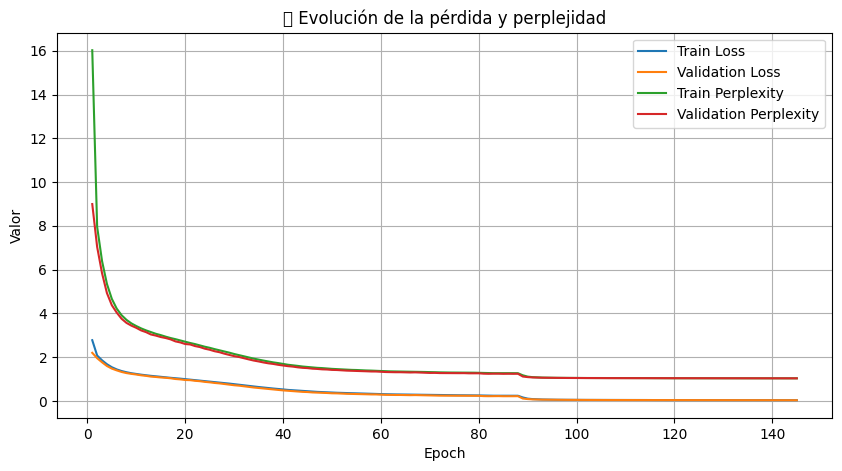

· Pérdida final de entrenamiento:     0.0310
· Perplejidad final de entrenamiento: 1.03
· Pérdida final de validación:     0.0308
· Perplejidad final de validación: 1.03


In [20]:
# Extraemos las métricas del historial de entrenamiento
loss_values = history.history["loss"]
val_loss_values = history.history["val_loss"]

# Calculamos la perplejidad tanto para entrenamiento como para validación
perplexity_values = [np.exp(l) for l in loss_values]
val_perplexity_values = [np.exp(l) for l in val_loss_values]

epochs = range(1, len(loss_values) + 1)

# Graficamos las métricas de pérdida y perplejidad para entrenamiento y validación
plt.figure(figsize=(10, 5))
plt.plot(epochs, loss_values, label="Train Loss")
plt.plot(epochs, val_loss_values, label="Validation Loss")
plt.plot(epochs, perplexity_values, label="Train Perplexity")
plt.plot(epochs, val_perplexity_values, label="Validation Perplexity")
plt.xlabel("Epoch")
plt.ylabel("Valor")
plt.title("📉 Evolución de la pérdida y perplejidad")
plt.legend()
plt.grid(True)
plt.show()

# Mostramos los valores finales de ambas métricas
print(f"· Pérdida final de entrenamiento:     {loss_values[-1]:.4f}")
print(f"· Perplejidad final de entrenamiento: {perplexity_values[-1]:.2f}")
print(f"· Pérdida final de validación:     {val_loss_values[-1]:.4f}")
print(f"· Perplejidad final de validación: {val_perplexity_values[-1]:.2f}")


## Generación de texto

### Definición de la clase OneStep


Esta clase encapsula el proceso de generación secuencial de texto, permitiendo generar texto de manera iterativa, carácter a carácter, a partir de un prompt inicial.

Funcionalidad que incorpora:
- Tokenización del input (ids_from_chars)

- Generación de logits con el modelo

- Aplicación de temperatura

- Muestreo con tf.random.categorical

- Máscara para evitar tokens [UNK]

- Decodificación del output (chars_from_ids)

In [21]:
class OneStep(tf.keras.Model):
    def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
        super().__init__()
        self.temperature = temperature
        self.model = model
        self.chars_from_ids = chars_from_ids
        self.ids_from_chars = ids_from_chars

        # Evitamos generar el token [UNK]
        skip_ids = self.ids_from_chars(["[UNK]"])[:, None]
        sparse_mask = tf.SparseTensor(
            indices=skip_ids,
            values=[-float("inf")] * len(skip_ids),
            dense_shape=[len(ids_from_chars.get_vocabulary())]
        )
        self.prediction_mask = tf.sparse.to_dense(sparse_mask)

    def generate_one_step(self, inputs, states=None):
        # Convertimos caracteres en IDs
        input_chars = tf.strings.unicode_split(inputs, "UTF-8")
        input_ids = self.ids_from_chars(input_chars).to_tensor()

        batch_size = tf.shape(input_ids)[0]

        # Ajuste de estado
        if states is not None:
            # Extraemos si es una tupla de un único tensor
            if isinstance(states, (tuple, list)) and len(states) == 1:
                states = states[0]
            # Expandimos si está colapsado
            if tf.rank(states) == 1:
                states = tf.expand_dims(states, 0)
            # Ajustamos al batch size actual
            if tf.shape(states)[0] != batch_size:
                states = tf.tile(states, [batch_size, 1])

        # Llamada al modelo
        if states is None:
            predicted_logits, new_states = self.model(
                input_ids, return_state=True, training=False
            )
        else:
            predicted_logits, new_states = self.model(
                input_ids, states=(states,), return_state=True, training=False
            )

        if isinstance(new_states, (tuple, list)) and len(new_states) == 1:
            new_states = new_states[0]

        # 🔥 Último paso de la secuencia
        predicted_logits = predicted_logits[:, -1, :]
        predicted_logits = predicted_logits / self.temperature
        predicted_logits += self.prediction_mask

        # Muestreo
        predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
        predicted_ids = tf.squeeze(predicted_ids, axis=-1)

        # Convertir IDs a texto
        predicted_chars = self.chars_from_ids(predicted_ids)

        return predicted_chars, new_states


¿Qué hace cada parte clave?

- `temperature`: controla la **aleatoriedad** de la generación (valores bajos = más predecible, valores altos = más creativo).
- `prediction_mask`: evita generar el token `[UNK]`, lo que mejora la calidad.
- `generate_one_step`: produce **un carácter a la vez**, útil para construir texto en un bucle.



### **Generación de texto al estilo Cervantes**

Aquí tienes un ejemplo listo para usar. Puedes ajustar el **prompt inicial**, la **temperatura** (creatividad) y la **longitud** del texto generado.


#### Sugerencias de parámetros

| Temperatura | Resultado esperado                 |
|-------------|-------------------------------------|
| `0.5`       | Texto más **estructurado** y seguro |
| `0.8`       | Equilibrio entre coherencia y creatividad |
| `1.0+`      | Resultados **más locos o poéticos** |

In [22]:
# Creamos una instancia del generador
one_step_model = OneStep(
    model,
    chars_from_ids=chars_from_ids,
    ids_from_chars=ids_from_chars,
    temperature=0.8
)

# Prompt inicial
start_prompt = "En un lugar de la Mancha"
states = None
next_char = tf.constant([start_prompt])
result = [next_char]

# Generamos texto carácter a carácter
for _ in range(1000):
    next_char, states = one_step_model.generate_one_step(next_char, states=states)
    result.append(next_char)

# Resultado final
generated_text = tf.strings.join(result).numpy()[0].decode("utf-8")
print("Texto generado:\n")
print(generated_text)


Texto generado:

En un lugar de la Mancha; la cual, con el
aposento y acomodado, captó con Anselmo, y todas partes a tus ojos
astanden se irme otra vez, y de nuevo se acabó la vida. Digo
que había acabado de hacerle aquella vitura con mucha propriedad y entendimiento
para todas las compasidas; y, como no fueron advertidos de las dos que
habían meses, que era un muchacho que las damas en aquella pintada y listimada
alguna, adonde se invidió don Quijote a la historia de don Quijote de la
Mancha, de mis dichos y dos gansamezos, y verás como se los hicieron esta carta
de sus padres, volvió a hacer menos cuanto le dijese qué modo de parte de
Dulcinea. De su escudero se puso del atrevido y hermosura, y luego dio en
su aposento de la caña, por lo cual don Quijote primero le escucharó si camina
muy aprobada entera, sin perjuicio, sacan sus libros y verdaderas. Hay
aquella montaña es que estaban empresa los dos malandrines historiadores cuanto
ensancha, no se entró por la puerta a pie por el su

###  Análisis de texto generado

- **Estilo sintáctico y léxico** muy cervantino:  
  Uso de frases extensas, formas como *"viniese"*, *"merced"*, *"hubiesen"*, etc.

- **Estructura dialogada**:  
  El modelo incluso introduce *guiones* y *diálogos*, algo que suele aprender por patrón visual.

- **Cohesión narrativa básica**:  
  Aunque hay partes incoherentes, el tono general y la atmósfera son consistentes con el **Don Quijote original**.

Esto confirma que:

- El modelo ha **aprendido patrones secuenciales** y estilo.
- La RNN (GRU) y el vocabulario funcionan correctamente.
- Podemos mejorar aún más aumentando *epochs*, ajustando *temperature*, o explorando *beam search*.


#### Generacion de texto con temperature=0.5

In [23]:
# Creamos una instancia del generador
one_step_model = OneStep(
    model,
    chars_from_ids=chars_from_ids,
    ids_from_chars=ids_from_chars,
    temperature=0.5
)

# Prompt inicial
start_prompt = "En un lugar de la Mancha"
states = None
next_char = tf.constant([start_prompt])
result = [next_char]

# Generamos texto carácter a carácter
for _ in range(1000):
    next_char, states = one_step_model.generate_one_step(next_char, states=states)
    result.append(next_char)

# Resultado final
generated_text = tf.strings.join(result).numpy()[0].decode("utf-8")
print("Texto generado:\n")
print(generated_text)

Texto generado:

En un lugar de la Mancha, y de la
misma manera que el cuerdo en la frente llevo.

— ¿Y no sé nada —respondió Sancho—; sólo estaba diciendo entre dos
mil suertes y levantados en alguna parte y en consigo con los escados
algunos de la ventana, y aun se lo ponde campensamientos. Y así, le dijo:

— Paréceme, señor caballero andante, que vuestra merced ha profesado una de
las más estrechas profesiones que hay en la tierra, y tengo para mí que aun
la de los frailes cartujos no es tan estrecha.

— Tan estrecha bien podía —dijo Sancho—, que me trae asimismo de abrirlar y
defender toda la informada del mundo, que pueda jurar como aquélla; que
los de la noche me han sacado de aquí se sustentar; y desta manera hará lo menos, yo pensar
que es verdad que todo lo que dices es tan valiente y tan desagradecida.
Finalmente, ha de ser atadas las promesas de los frailes cargan con quien
alcanzares; porque suelen los encantos de la vida, si se entreta, sino que
te digo que me den la venga

In [27]:
# Creamos una instancia del generador
one_step_model = OneStep(
    model,
    chars_from_ids=chars_from_ids,
    ids_from_chars=ids_from_chars,
    temperature=2.0
)

# Prompt inicial
start_prompt = "En un lugar de la Mancha"
states = None
next_char = tf.constant([start_prompt])
result = [next_char]

# Generamos texto carácter a carácter
for _ in range(1000):
    next_char, states = one_step_model.generate_one_step(next_char, states=states)
    result.append(next_char)

# Resultado final
generated_text = tf.strings.join(result).numpy()[0].decode("utf-8")
print("Texto generado:\n")
print(generated_text)

Texto generado:

En un lugar de la Mancha es mi
maleta, harto contra villanos callanos; uno del soldado, asió de venta
trinco, la rienda. ToméO, el principao de Tote de ser abajo, ya. Yo le levantó muy comenzó a
Garcilas, La Resonumar en lugar, cuando el hombre hizo sed mentecato; y
Dásgase cuando se le cayeron en una buena pieza; y, tuyo; sepa que no
andebo de dolor se le arrancaba el alma.
Hizcaído, pues, entre aquella tierra y juitamente, luego había
salido cancionoslas, al cual decían: no consentiro qué nadiemo, diego entre el
mesmo Grisólo con el Papa, se le quita y le enmiesen los galeotes; menoscaba rico;
pero vi y tan saré al cautivo, que era la que profesabo. en las
manos y pie de escuderos y socapada el aspetur de Quicen. Venga España, y
Amadís de Maute, ni nosotras fingidas tantos y colas. No le diera aseg,
al pie de la lengua n diste, y más cruces escuderos de locura que la Golsema,
que traer en la cabeza en el mundo con esta exculpa: que esto imagino
y su dolor de los amor

---

## Generación de texto con `Beam Search`

Hasta ahora, generábamos texto carácter a carácter usando muestreo aleatorio con tf.random.categorical. Este enfoque introduce creatividad, pero también puede generar incoherencias o secuencias menos estructuradas.

En esta sección, implementamos un enfoque más estructurado y determinista:

- Beam Search, una técnica que explora múltiples caminos posibles en paralelo para encontrar secuencias más coherentes.

#### ¿Qué es Beam Search?


Beam Search es una técnica heurística que mantiene vivas las k mejores secuencias en cada paso, en lugar de solo una.

- Inicio: se parte de un prompt inicial (start_prompt) y un estado nulo.

- Iteración:

    - Se generan predicciones para cada secuencia viva en el beam.

    - Se seleccionan las k combinaciones más prometedoras de secuencia + siguiente carácter.

    - Se calcula la probabilidad acumulada de cada camino.

- Finalización:

    - Tras num_steps, se devuelve la secuencia con mayor probabilidad acumulada.

#### Parámetros clave de la función


`beam_width`:
- Número de secuencias que se mantienen en cada paso.
- Un valor mayor permite más exploración, pero también es más costoso computacionalmente.

`temperature`:
- Suaviza la distribución de salida.
- Valores más altos → más aleatoriedad.
- Valores bajos → decisiones más deterministas.

`num_steps`:
- Longitud total del texto a generar (en número de caracteres).

#### Lógica de generación paso a paso

1. Se parte del **prompt inicial**, convertido a IDs.
2. En cada paso:
   - Se generan predicciones para todas las secuencias vivas.
   - Se seleccionan las mejores combinaciones de secuencias y próximos caracteres.
3. Al finalizar, se selecciona la mejor secuencia generada según la probabilidad acumulada.

#### Implementacion

In [24]:
class BeamSearchGenerator:
    def __init__(self, model, ids_from_chars, chars_from_ids, beam_width=3, temperature=1.0):
        self.model = model
        self.ids_from_chars = ids_from_chars
        self.chars_from_ids = chars_from_ids
        self.beam_width = beam_width
        self.temperature = temperature

        # Máscara para evitar el token [UNK]
        skip_ids = self.ids_from_chars(["[UNK]"])[:, None]
        sparse_mask = tf.SparseTensor(
            indices=skip_ids,
            values=[-float("inf")] * len(skip_ids),
            dense_shape=[len(self.ids_from_chars.get_vocabulary())]
        )
        self.prediction_mask = tf.sparse.to_dense(sparse_mask)

    def generate(self, start_prompt, num_steps):
        initial_state = None
        initial_char = tf.constant([start_prompt])
        beams = [(0.0, initial_state, initial_char)]

        for _ in range(num_steps):
            all_candidates = []

            for log_prob, state, seq in beams:
                # Paso 1: Convertimos el prompt a IDs
                input_chars = tf.strings.unicode_split(seq, "UTF-8")
                input_ids = self.ids_from_chars(input_chars).to_tensor()

                # Paso 2: Ajustamos el estado como en OneStep
                if state is not None:
                    if isinstance(state, (tuple, list)) and len(state) == 1:
                        state = state[0]
                    if tf.rank(state) == 1:
                        state = tf.expand_dims(state, 0)
                    if tf.shape(state)[0] != tf.shape(input_ids)[0]:
                        state = tf.tile(state, [tf.shape(input_ids)[0], 1])
                    model_output = self.model(
                        input_ids, states=(state,), return_state=True, training=False
                    )
                else:
                    model_output = self.model(
                        input_ids, return_state=True, training=False
                    )

                logits, new_state = model_output
                if isinstance(new_state, (tuple, list)) and len(new_state) == 1:
                    new_state = new_state[0]

                # Paso 3: Último logit + temperatura + máscara
                logits = logits[:, -1, :] / self.temperature
                logits += self.prediction_mask
                log_probs = tf.nn.log_softmax(logits)

                # Paso 4: top-k predicciones
                top_k_log_probs, top_k_ids = tf.math.top_k(log_probs, k=self.beam_width)

                for i in range(self.beam_width):
                    char_id = top_k_ids[0][i]
                    char = self.chars_from_ids(char_id[tf.newaxis])
                    new_seq = tf.strings.join([seq, char])
                    new_log_prob = log_prob + top_k_log_probs[0][i].numpy()
                    all_candidates.append((new_log_prob, new_state, new_seq))

            # Paso 5: seleccionar los mejores k candidatos
            all_candidates = sorted(all_candidates, key=lambda x: x[0], reverse=True)
            beams = all_candidates[:self.beam_width]

        # Secuencia más probable
        best_sequence = beams[0][2]
        return best_sequence.numpy()[0].decode("utf-8")


In [25]:
beam_generator = BeamSearchGenerator(
    model,
    ids_from_chars=ids_from_chars,
    chars_from_ids=chars_from_ids,
    beam_width=5,
    temperature=0.5
)

prompt = "En un lugar de la Mancha"
generated_text = beam_generator.generate(prompt, num_steps=1000)

print("📝 Texto generado con Beam Search:")
print(generated_text)


📝 Texto generado con Beam Search:
En un lugar de la Mancha; la
cual, como vio que de algunos perdones historiador que tengo de vengar
sus desventuras, ni aun con los martirios de la pereza, sino volvamos
a estorbarlo, que la causa de las malas razones, ordenó de todos los dos días a
los hombres. Digo esto, Sancho, porque en mí uno me hubiera muerto;
porque no es bien que los caballeros andantes dan trastroso como vuestra
merced, se vee en la silla de Babieca en la silla, de mi cuenta, tanto
es el señor don Quijote, que debe de ser principal y riquezas.

— No es menester mucho —dijo a esta sazón don Quijote—, que yo soy de la Mancha,
cuyas hojas le entraron a don Quijote y a Sancho, a quien dio los diez escudos
desotros.

Digo, pues, que los diese en el suelo, y luego conocido y conservando en los
moros de lágrimas y comenzaron a encomendarse a su contrario, y lo mesmo hizo el
ausencia de don Quijote, y pusiéronse a caminar tras el carro. Y la
honraba en el suelo, junto al primero que d

In [26]:
beam_generator = BeamSearchGenerator(
    model,
    ids_from_chars=ids_from_chars,
    chars_from_ids=chars_from_ids,
    beam_width=3,
    temperature=0.8
)

prompt = "En un lugar de la Mancha"
generated_text = beam_generator.generate(prompt, num_steps=1000)

print("📝 Texto generado con Beam Search:")
print(generated_text)


📝 Texto generado con Beam Search:
En un lugar de la Mancha; la
cual, como vio que de algunos perdones historiador que tengo de vengar
sus desventuras, ni aun con los martirios de la pereza, sino volvamos
a estorbarlo, que la causa de las malas razones, ordenó de todos los dos días a
los hombres. Digo esto, Sancho, porque bien me servía desta manera:




Capítulo XXXIX. Donde el cautivo cuenta su vida y sucesos

— «En un lugar de las Montañas de León tuvo principio mi linaje, con quien
fue más agradecida y liberal la naturaleza que la fortuna, aunque, en la
estrecheza de mi deseo, soy don Quijote, que se halló en él una hora, y el
cura le había prometido que le echare de ver la entena de los reyes, esperaban los
mozos de plata; el cual, como llegó con la duquesa a las piernas de
Rocinante y de su rostro, con cuyo suceso que debía de estar encantado,
con las mejores razones que con él estaban espírituvemente. En efeto nuestro
lugar, tornó a dar señales de saberse y de color todo lo que p

---

## Generación de texto  con `Greedy search`

Greedy Search es un enfoque determinista para la generación de texto en el que, en cada paso, se selecciona el token con la mayor probabilidad de manera directa, sin explorar otras alternativas. Esto puede resultar en salidas muy coherentes, aunque a veces menos diversas.

#### ¿Qué es Greedy Search?
- **Determinismo:** En cada paso se escoge el token más probable (usando `tf.argmax`), lo que produce resultados predecibles.
- **Proceso:** Se parte de un prompt inicial y, en cada iteración, se actualiza la secuencia con el token seleccionado, manteniendo y actualizando el estado del modelo.
- **Resultado:** Al finalizar un número determinado de pasos, se devuelve la secuencia completa generada.

#### Parámetros Clave
- **Temperature:** Ajusta la suavidad de la distribución de probabilidad. Con valores bajos la salida es aún más determinista.
- **num_steps:** Número total de tokens (o caracteres) a generar.
- **Estado:** Se actualiza en cada paso para conservar el contexto de la secuencia.

#### Lógica de Generación Paso a Paso
1. **Inicio:** Convertir el prompt inicial a IDs y establecer el estado inicial en `None`.
2. **Iteración:**  
   - Pasar la secuencia actual y el estado al modelo para obtener los logits y el nuevo estado.
   - Aplicar la temperatura (dividiendo los logits) y sumar una máscara (para evitar tokens indeseados, como `[UNK]`).
   - Seleccionar el token con la mayor probabilidad usando `tf.argmax`.
   - Convertir el token a su representación en texto y añadirlo a la secuencia.
3. **Finalización:** Después de `num_steps`, unir los tokens generados y devolver el texto final.

#### Implementación

In [32]:
class GreedySearchGenerator:
    def __init__(self, model, ids_from_chars, chars_from_ids, temperature=1.0):
        self.model = model
        self.ids_from_chars = ids_from_chars
        self.chars_from_ids = chars_from_ids
        self.temperature = temperature

        # Máscara para evitar generar el token [UNK]
        skip_ids = self.ids_from_chars(["[UNK]"])[:, None]
        num_skip_ids = int(tf.shape(skip_ids)[0])
        sparse_mask = tf.SparseTensor(
            indices=skip_ids,
            values=[-float("inf")] * num_skip_ids,
            dense_shape=[len(self.ids_from_chars.get_vocabulary())]
        )
        self.prediction_mask = tf.sparse.to_dense(sparse_mask)

    def generate(self, start_prompt, num_steps):
        # Convertir el prompt inicial a un tensor
        input_text = tf.constant([start_prompt])
        state = None
        result = [input_text]

        for _ in range(num_steps):
            # Convertir el texto actual a IDs
            input_chars = tf.strings.unicode_split(input_text, "UTF-8")
            input_ids = self.ids_from_chars(input_chars).to_tensor()

            # Ajustamos el estado si ya existe
            if state is not None:
                if isinstance(state, (tuple, list)) and len(state) == 1:
                    state = state[0]
                if tf.rank(state) == 1:
                    state = tf.expand_dims(state, 0)
                if tf.shape(state)[0] != tf.shape(input_ids)[0]:
                    state = tf.tile(state, [tf.shape(input_ids)[0], 1])
                logits, state = self.model(input_ids, states=(state,), return_state=True, training=False)
            else:
                logits, state = self.model(input_ids, return_state=True, training=False)

            # Tomamos el logit del último paso, aplicamos temperatura y máscara
            logits = logits[:, -1, :] / self.temperature
            logits += self.prediction_mask

            # Seleccionamos el token con mayor probabilidad (greedy)
            next_id = tf.argmax(logits, axis=-1, output_type=tf.int32)
            next_char = self.chars_from_ids(next_id)

            # Actualizamos el input y acumulamos el resultado
            input_text = tf.strings.join([input_text, next_char])
            result.append(next_char)

        # Convertimos la secuencia generada a string
        return tf.strings.join(result).numpy()[0].decode("utf-8")


In [34]:
greedy_generator = GreedySearchGenerator(
    model,
    ids_from_chars=ids_from_chars,
    chars_from_ids=chars_from_ids,
    temperature=0.8
)

prompt = "En un lugar de la Mancha"
generated_text = greedy_generator.generate(prompt, num_steps=1000)

print("📝 Texto generado con Greedy Search:")
print(generated_text)

📝 Texto generado con Greedy Search:
En un lugar de la Mancha; la
cual, como vio que de algunos perdones historiador que tengo de vengar
sus desventuras, ni aun con los martirios de la pereza, sino volvamos a
estar solo entre los moros que a mí y a este rey en dineros en esta grande
historia que no quiere decir en ella millares de otro mal a ninguno.

— Pues lo mesmo —dijo don Quijote— porque no ha sido suya ser emperador, y verá
que se me dé a mí por ocho día, y es de más imaginaciones y
demasiadoles cada mes''. Y tú, Sancho, cuanto más, habiendo hecho
estos días que te han de alcanzar el vato.

— En esta invención de la historia —respondió Sancho Panza—, sólo sé decir que
si de las noches vale ostende esta nuestra cédula y en la opinión
de don Quijote.

— Así me parece a mí —respondió Cardenio—, porque, según da indicio, él
tiene por cierto que todo lo que estos libros cuentan pasó ni más ni menos
que lo escriben, y no le harán creer otra cosa frailes descalzos.
— Mentís con pie de pa


---

## Generación de texto  con `Top-k Sampling`

Top-k Sampling es una técnica que, en cada paso, restringe el muestreo al conjunto de los *k* tokens con mayor probabilidad. Este método permite mantener una salida coherente al limitar las opciones a las más probables, pero a la vez introduce diversidad al muestrear de forma aleatoria entre estas opciones.

#### ¿Qué es Top-k Sampling?
- **Restricción:** En cada paso se consideran únicamente los *k* tokens con mayores probabilidades.
- **Diversidad Controlada:** Aunque se muestrea de forma aleatoria, limitar el conjunto a los *k* mejores candidatos tiende a producir salidas coherentes.
- **Proceso:** Se parte del prompt inicial y, en cada iteración, se:
  - Genera la distribución de probabilidad para el siguiente token.
  - Extrae los *k* tokens con mayor probabilidad.
  - Aplica softmax a estos valores para obtener una distribución normalizada.
  - Muestrea aleatoriamente un token de este conjunto restringido.
  - Actualiza la secuencia y el estado del modelo.

#### Parámetros Clave
- **k (Top-k):** Número de tokens candidatos a considerar en cada paso. Valores moderados (por ejemplo, entre 10 y 20) suelen equilibrar coherencia y diversidad.
- **Temperature:** Ajusta la distribución de probabilidades; valores cercanos a 1 mantienen un balance, mientras que valores menores la hacen más determinista.
- **num_steps:** Número total de tokens a generar.
- **Estado:** Se actualiza a lo largo de la generación para conservar el contexto.

#### Lógica de Generación Paso a Paso
1. **Inicio:** Convertir el prompt inicial a IDs y definir el estado inicial en `None`.
2. **Iteración:**  
   - Alimentar la secuencia actual (junto con el estado, si existe) al modelo para obtener los logits y el nuevo estado.
   - Extraer los logits del último token, aplicar la temperatura y la máscara.
   - Utilizar `tf.math.top_k` para obtener los *k* tokens con mayores probabilidades y sus respectivos valores.
   - Calcular la distribución softmax de estos valores y muestrear un token aleatoriamente de entre ellos.
   - Convertir el token muestreado a texto y actualizar la secuencia y el estado.
3. **Finalización:** Al completar `num_steps`, unir todos los tokens generados y devolver la secuencia final.


#### Implementación

In [35]:
class TopKSampler:
    def __init__(self, model, ids_from_chars, chars_from_ids, k=10, temperature=1.0):
        self.model = model
        self.ids_from_chars = ids_from_chars
        self.chars_from_ids = chars_from_ids
        self.k = k
        self.temperature = temperature

        # Máscara para evitar generar el token [UNK]
        skip_ids = self.ids_from_chars(["[UNK]"])[:, None]
        num_skip_ids = int(tf.shape(skip_ids)[0])
        sparse_mask = tf.SparseTensor(
            indices=skip_ids,
            values=[-float("inf")] * num_skip_ids,
            dense_shape=[len(self.ids_from_chars.get_vocabulary())]
        )
        self.prediction_mask = tf.sparse.to_dense(sparse_mask)

    def generate(self, start_prompt, num_steps):
        # Inicializamos con el prompt y estado nulo
        input_text = tf.constant([start_prompt])
        state = None
        result = [input_text]

        for _ in range(num_steps):
            # Convertimos el texto actual a IDs
            input_chars = tf.strings.unicode_split(input_text, "UTF-8")
            input_ids = self.ids_from_chars(input_chars).to_tensor()

            # Ajustamos el estado si ya existe
            if state is not None:
                if isinstance(state, (tuple, list)) and len(state) == 1:
                    state = state[0]
                if tf.rank(state) == 1:
                    state = tf.expand_dims(state, 0)
                if tf.shape(state)[0] != tf.shape(input_ids)[0]:
                    state = tf.tile(state, [tf.shape(input_ids)[0], 1])
                logits, state = self.model(input_ids, states=(state,), return_state=True, training=False)
            else:
                logits, state = self.model(input_ids, return_state=True, training=False)

            # Tomamos los logits del último paso, aplicamos temperatura y máscara
            logits = logits[:, -1, :] / self.temperature
            logits += self.prediction_mask

            # Extraemos los top-k tokens
            topk_values, topk_ids = tf.math.top_k(logits, k=self.k)
            # Convertimos los valores a probabilidades
            topk_probs = tf.nn.softmax(topk_values)

            # Muestreamos de la distribución top-k (usando logaritmos para estabilidad numérica)
            # tf.random.categorical requiere logits; por ello, aplicamos tf.math.log a topk_probs
            sampled = tf.random.categorical(tf.math.log(topk_probs), num_samples=1)
            sampled = tf.squeeze(sampled, axis=-1)  # forma: [batch_size] (batch_size=1)

            # Obtenemos el token real a partir de topk_ids
            selected_token = tf.gather(topk_ids, sampled, axis=1)
            next_id = tf.squeeze(selected_token, axis=0)
            next_char = self.chars_from_ids(next_id)

            # Actualizamos el prompt y acumulamos el resultado
            input_text = tf.strings.join([input_text, next_char])
            result.append(next_char)

        return tf.strings.join(result).numpy()[0].decode("utf-8")


In [37]:
topk_sampler = TopKSampler(
    model,
    ids_from_chars=ids_from_chars,
    chars_from_ids=chars_from_ids,
    k=10,           # Puedes ajustar k; valores moderados (10-20) suelen dar buena coherencia
    temperature=1.0 # Temperatura cercana a 1 para mantener la diversidad
)

prompt = "En un lugar de la Mancha"
generated_text = topk_sampler.generate(prompt, num_steps=1000)

print("📝 Texto generado con Top-k Sampling:")
print(generated_text)

📝 Texto generado con Top-k Sampling:
En un lugar de la Mancha, de
Montemano, colmándole por el gobierno y a las manos, me puso al lecho y dejamos, conservando, y
mata, ya por hombre de todo se torna a dormir entrambos. Tenía el viaje conoció a
las Indias, las cuales comprarían ya conocida, y con voz baja le
vendía, y descubrió con la mujer de Sancho, y aun la mitad del
camino, sin saber lo que don Quijote hacía servido de darle era de
camino, en la pelea, atrevido y malfrejale, todo amor y mozo, ni mucha
descolgada en los de la maleta.
Como sois el ventero, a quien don Quijote la si, ye
doba, por hacerle perfecio de responder que se estaba en Bayzar, que no le
desampare.

»— No quiero pagar —respondió Sancho— que los presentes están llenas destas siestas, tanta
filesicordia hecha y de diamantes, y padé antes caballeros andantes en
el diablo, como lo sates; y, por no ser armado caballero, no ponga los poetas
que son muchos los pensamientos que en punta de las fueves a la
galancha? ¿Qué 

In [45]:
topk_sampler = TopKSampler(
    model,
    ids_from_chars=ids_from_chars,
    chars_from_ids=chars_from_ids,
    k=30,           
    temperature=0.7
)

prompt = "En un lugar de la Mancha"
generated_text = topk_sampler.generate(prompt, num_steps=1000)

print("📝 Texto generado con Top-k Sampling:")
print(generated_text)

📝 Texto generado con Top-k Sampling:
En un lugar de la Mancha, a
quien tocaba una guitarra que la que se dice que se detuviera, y el maestresala pon
otros sucesos de aquellos que las tenga y contingea la república,
porque todos se acomodasen a la mañana, en que se entretiene.

Nuevo este negocio estaba puesta la mano y la conforme a los parientes
del bosque, contra el uso de los pies de don Quijote, y ella, la más rara
habilidad es que nos libre autendían a sus camasarnes; las colas, llenos de
enemigos, y otras tantas verdades, les dijesen: costumbre en
riscones y su escudero, yo me sace a subir sobre una serpiente en que
la guerra que aquel a ciento de enamorado. Y si no fuese porque
imagino..., ¿qué digo imagino?, sé muy cierto, que todas estas
incomodidades son muy anejas al ejercicio de las armas, aquí me dejaría
morir de puro enojo.

A esto replicó el escudero:

— Señor, ya se sobró quisiere, si no han oído decir voluntad al caso, a quien te
tengo puesto en aquella sazón a cosa de